In [1]:
import matplotlib.pylab as pl
import shap
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from functools import reduce
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
df = pd.read_csv(
    '/Users/jemma/Desktop/LifeBook/table_chronic_liver_disease_no_rescale.csv')

In [3]:
df = df[df.columns[2:].to_list()]
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 24 columns):
RIAGENDR      536 non-null int64
RIDAGEYR      536 non-null int64
RIDRETH3_3    536 non-null int64
RIDRETH3_4    536 non-null int64
RIDRETH3_1    536 non-null int64
RIDRETH3_2    536 non-null int64
RIDRETH3_6    536 non-null int64
RIDRETH3_7    536 non-null int64
DIQ010        536 non-null int64
HEQ010        536 non-null int64
HEQ030        536 non-null int64
ALQ151        536 non-null int64
ALQ160        536 non-null int64
KIQ022        536 non-null int64
MCQ160L       536 non-null int64
LBXSATSI      536 non-null int64
LBXSASSI      536 non-null int64
LBXSAPSI      536 non-null int64
LBDSALSI      536 non-null int64
LBXSTB        536 non-null float64
LBXSGTSI      536 non-null int64
BMXBMI        536 non-null float64
BMXWAIST      536 non-null float64
LBXTR         536 non-null int64
dtypes: float64(3), int64(21)
memory usage: 100.6 KB


(536, 24)

In [4]:
y=df['MCQ160L'].values
x_columns = set(df.columns)
x_columns.remove('MCQ160L')
X=df[x_columns].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Logistic Regression Classifier

In [5]:
class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, y, random_state=42, criterion='entropy'):
        X_train_p = X[y==1]
        X_train_n = X[y==0]
        y_train_p = y[y==1]
        y_train_n = y[y==0]
        l = sum(y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            y_train_f = np.concatenate([y_train_n[idx_n], y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs)) # proba of label: y==1
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, y):
        y_hat = self.predict(X)
        print(classification_report(y_test, 1.*(y_hat>0.5)))
    
    def predict_proba(self,X):
        result_list = list(map(lambda clf: 100*clf.predict_proba(X)[:,1], self.clfs))
        proba = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return proba

In [6]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)

Classifier 500 completed.

In [7]:
btc.coefficients()

array([[ 0.27577321, -0.05761222,  0.14399551, -0.31354411,  0.00741021,
         0.04650798, -0.01099412, -0.17827471,  0.12369169, -0.06769772,
        -0.03385401,  0.19831264,  0.06852816,  0.13828315, -0.3455992 ,
        -0.04526338,  0.16454983, -0.0288483 ,  0.47094497,  0.24904789,
         0.04178159, -0.00540703,  0.0795031 ]])

In [8]:
reshaped_X_test = pd.DataFrame(X_test)
reshaped_X_test.index = np.arange(1,len(reshaped_X_test)+1)

In [9]:
predictors_name = pd.DataFrame(df[df.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
predictors_name_transpose = predictors_name.transpose()

In [10]:
reshaped_risk_score = pd.DataFrame(btc.predict_proba(X_test).reshape(-1,1))
reshaped_risk_score.index = np.arange(1,len(reshaped_risk_score)+1)
risk_score_tb = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score_tb_final = risk_score_tb.rename(columns= predictors_name_transpose.loc[0])
#risk_score_tb_final.to_excel('risk_score_tb_final.xls')

In [11]:
risk_score_tb_final.head()

,RIAGENDR,RIDAGEYR,RIDRETH3_3,RIDRETH3_4,RIDRETH3_1,RIDRETH3_2,RIDRETH3_6,RIDRETH3_7,DIQ010,HEQ010,...,MCQ160L,LBXSATSI,LBXSASSI,LBXSAPSI,LBDSALSI,LBXSTB,LBXSGTSI,BMXBMI,BMXWAIST,Risk Score
1,1.0,0.0,0.0,30.2,108.0,38.0,0.0,0.0,0.0,1.0,...,42.0,34.0,40.0,0.0,0.0,1.0,0.0,69.0,0.7,24.600334
2,1.0,0.0,0.0,31.4,41.0,20.0,0.0,1.0,0.0,0.0,...,40.0,17.0,42.0,0.0,0.0,3.0,0.0,48.0,0.7,19.920447
3,1.0,0.0,0.0,32.3,368.0,43.0,0.0,0.0,0.0,1.0,...,44.0,63.0,26.0,0.0,0.0,0.0,0.0,114.0,0.8,40.404795
4,0.0,0.0,0.0,26.0,130.0,30.0,0.0,0.0,1.0,0.0,...,42.0,15.0,35.0,0.0,0.0,4.0,0.0,39.0,0.7,26.829017
5,1.0,0.0,0.0,28.6,123.0,115.0,0.0,0.0,0.0,1.0,...,49.0,61.0,36.0,0.0,0.0,0.0,0.0,72.0,0.4,31.789611


In [12]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors_final = pd.DataFrame(df[df.columns[0:-1]].columns)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)

In [13]:
print(classification_report(y_true=y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       153
           1       0.13      0.38      0.19         8

    accuracy                           0.84       161
   macro avg       0.55      0.62      0.55       161
weighted avg       0.92      0.84      0.88       161



In [14]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, y_train)
y_hat_train = 1.0 * (btc.predict(X_train)>0.5)

Classifier 329 completed.

Classifier 500 completed.

In [15]:
print(classification_report(y_true=y_train, y_pred=y_hat_train))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       361
           1       0.18      0.86      0.30        14

    accuracy                           0.85       375
   macro avg       0.59      0.86      0.61       375
weighted avg       0.96      0.85      0.90       375



In [16]:
confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[133,  20],
       [  5,   3]])

In [17]:
coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
#coefficient_tb_final.to_csv('coefficient_tb_final.csv')

,Predictor,Coefficient
19,LBDSALSI,0.470945
1,RIAGENDR,0.275773
20,LBXSTB,0.249048
12,ALQ151,0.198313
17,LBXSASSI,0.164550
3,RIDRETH3_3,0.143996
14,KIQ022,0.138283
9,DIQ010,0.123692
23,BMXWAIST,0.079503
13,ALQ160,0.068528


In [18]:
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [19]:
score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
13,ALQ160,14.551203
23,BMXWAIST,16.881611
9,DIQ010,26.264575
14,KIQ022,29.362911
3,RIDRETH3_3,30.575868
17,LBXSASSI,34.940352
12,ALQ151,42.109515
20,LBXSTB,52.882589
1,RIAGENDR,58.557418
19,LBDSALSI,100.000000


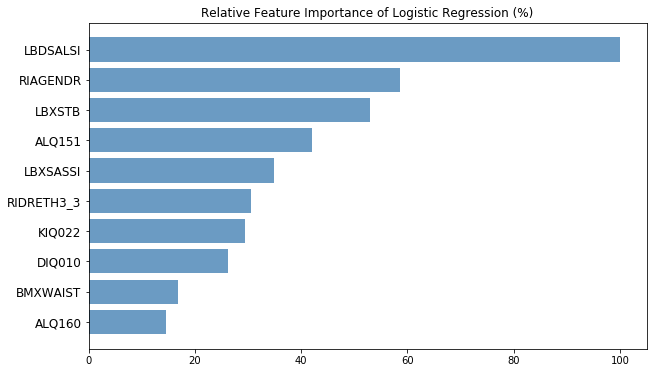

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
#ax.set_xlabels('Relative Feature Importance (%)')
#xticks(np.arange(10), ['Tom', 'Dick', 'Sue',]) 
#plt.tight_layout()   
plt.title('Relative Feature Importance of Logistic Regression (%)')
plt.show()

## XGBoost

import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

#### find the best parameter

nmc = 100 

#### set up dictionary for grid search
####  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight}
#### set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
#### set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
#### implement search
grid_search.fit(X,y)
#### move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma']])

In [21]:
# use best parameters: max_depth= 3, min_child_weight= 1, gamma=0
from xgboost import XGBClassifier
xgb = XGBClassifier(
 max_depth= 3, 
 min_child_weight= 1,
 gamma=0,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)


xgb.fit(X_train,y_train)
print('Training score:', xgb.score(X_train,y_train))
print('Testing score:',xgb.score(X_test,y_test))

Training score: 1.0
Testing score: 0.937888198757764


In [22]:
# confusion matrix        
pred = xgb.predict(X_test)
confusion_matrix(y_true=y_test, y_pred=pred)

array([[151,   2],
       [  8,   0]])

In [23]:
print(classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       153
           1       0.00      0.00      0.00         8

    accuracy                           0.94       161
   macro avg       0.47      0.49      0.48       161
weighted avg       0.90      0.94      0.92       161



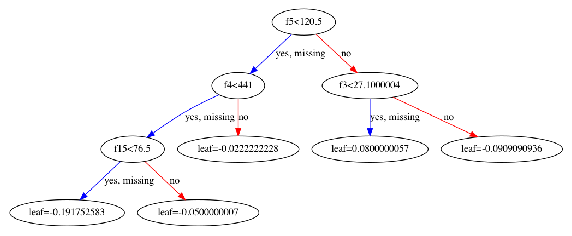

In [24]:
from matplotlib.pylab import rcParams
from xgboost import XGBClassifier
rcParams['figure.figsize'] = 10,10
tree_num = 0
xgboost.plot_tree(xgb,num_trees=tree_num)

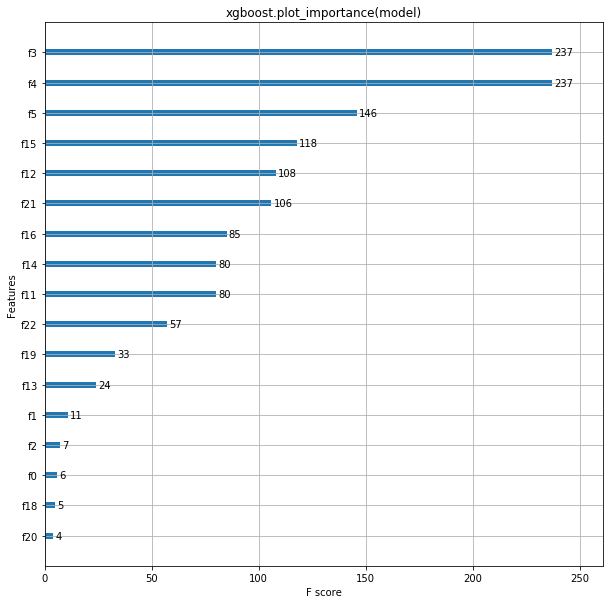

In [25]:
xgboost.plot_importance(xgb)
pl.title("xgboost.plot_importance(model)")
pl.show()

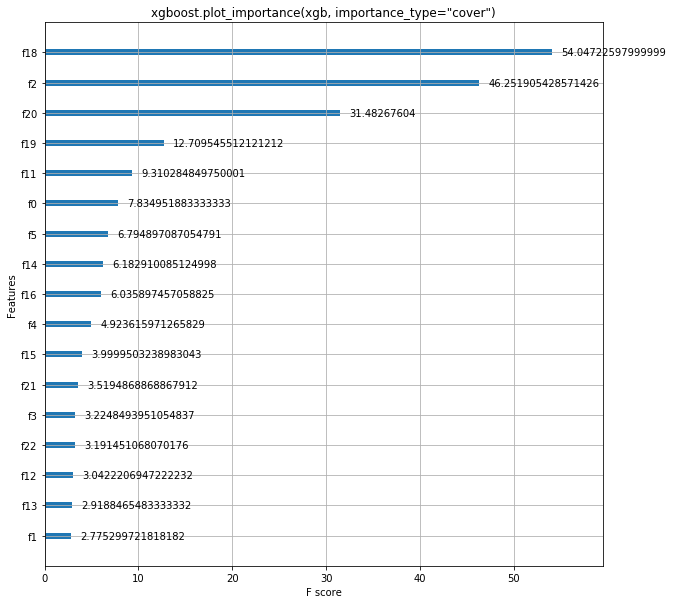

In [26]:
xgboost.plot_importance(xgb, importance_type="cover")
pl.title('xgboost.plot_importance(xgb, importance_type="cover")')
pl.show()

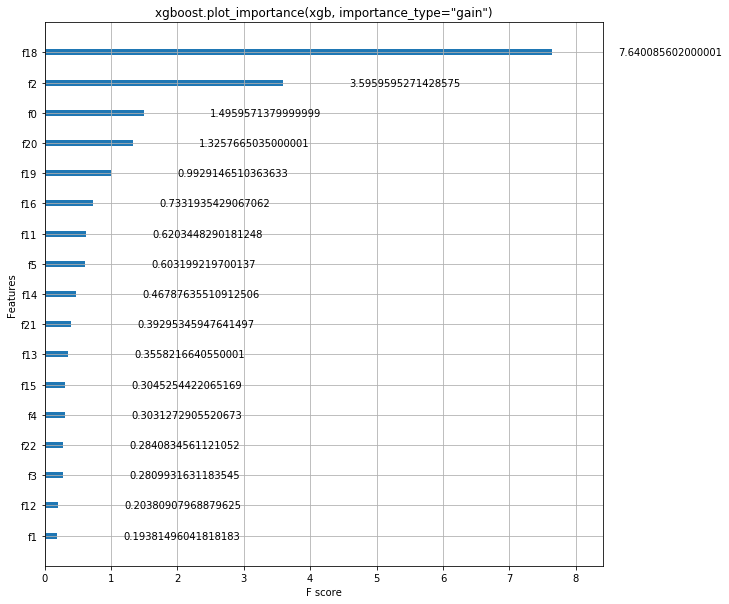

In [27]:
xgboost.plot_importance(xgb, importance_type="gain")
pl.title('xgboost.plot_importance(xgb, importance_type="gain")')
pl.show()

In [28]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

In [29]:
X_variable = df[df.columns[0:-1]]

In [30]:
shap.force_plot(explainer.expected_value, shap_values[0,:],X_variable.iloc[0,:])

In [31]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_variable.iloc[:1000,:])

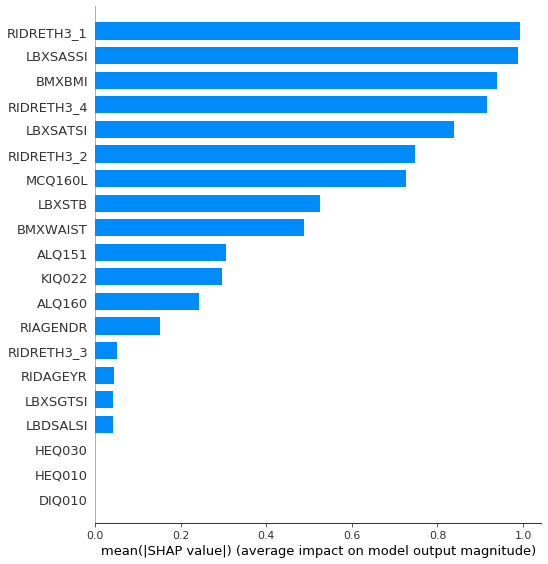

In [32]:
shap.summary_plot(shap_values, X_variable, plot_type="bar")

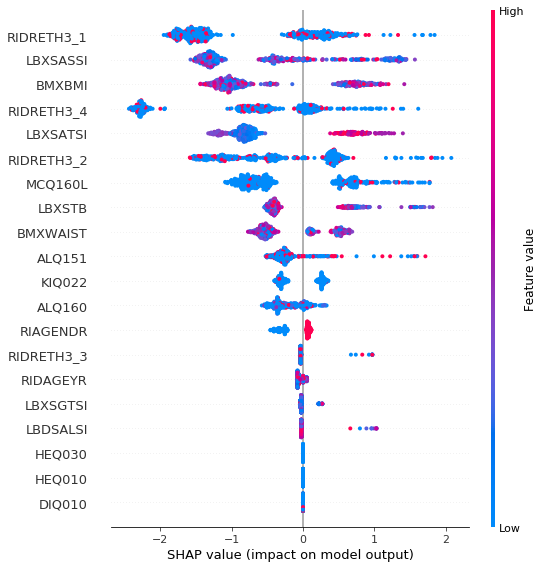

In [33]:
shap.summary_plot(shap_values, X_variable)